# CS224W Final Project: Tutorial on the Augmentation of Graphs in PyG

### Jerry Chan, Jihee Suh, John So

Data augmentation is a widely used technique that leverages existing data to further train a model, improving its performance and generalization. For structured data formats such as images, augmentation methods can be quite straightforward, including operations like cropping, resizing, rotating, and adding noise. These augmentations are useful for reducing overfitting to the training dataset and adding invariance to certain transformations, such as color shifts, different camera models, and even different camera poses. 

In graphs, where a local spatial area is not quite as evenly defined, a good augmentation scheme is less obvious, but still remains powerful ways to reduce overfitting. Beyond robustness, graph augmentations can address noted issues, including over-smoothing, aggregation schemes, and graph structure learning to create powerful GNNs. 

In this tutorial, we aim to provide an intuitive explanation to various graph augmentation schemes. PyG provides several tools to manipulate the underlying graph structure and features, as well as dynamically manipulate them during training time. Using PyG, we will walk through setting up different graph learning problems, apply each augmentation scheme, and demonstrate when using each is a good idea.


## Installation and Setup

### Notebook setup: install PyG + torch

In [1]:
import torch
torch_version = str(torch.__version__)
if "2.4.0" not in torch_version:
  !pip install torch==2.4.0

In [2]:
print(torch_version)

2.4.0+cu121


In [3]:
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install ogb

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-2.4.0+cu121.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import random

import numpy as np
from tqdm import tqdm

import torch
from torch_geometric.nn.models import GraphSAGE
from torch_geometric.loader import NeighborLoader
import torch_geometric.transforms as T
from torch_geometric.utils import to_undirected
from torch_geometric.datasets import KarateClub
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

In [5]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Dataset and Tasks



To demonstrate the power of graph augmentations, let’s consider a realistic, grounded graph to benchmark on. The Open Graph Benchmark (OGB) provides many such graphs, including ogbn-arxiv, which we utilize here. Ogbn-arxiv is also a multi-class classification task, but is of smaller scale with ~170K nodes and ~1.2M edges, and represents the citation network between arXiv papers.


Ogbn-arxiv has its own split: it trains on papers published until 2017, validates on 2018 papers, then tests on the rest. We will leverage these splits for an inductive learning setting and see how different augmentations affect generalization.

In [6]:
def load_dataset(transform=None):
    dataset = PygNodePropPredDataset(name='ogbn-arxiv', root='./arxiv/', transform=transform)
    print(dataset, flush=True)
    data = dataset[0]
    print(data, flush=True)
    return dataset

In [7]:
dataset = load_dataset()

/home/adel/.local/lib/python3.8/site-packages/ogb/nodeproppred/dataset_pyg.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(self.proc

PygNodePropPredDataset()
Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


### Training and Evaluation Utilities

To keep experiments consistent, we will use one network architecture throughout this tutorial. We will use a 4-layer GraphSAGE model followed by dropout, ReLU activation, and a linear layer for the classification head. The GraphSAGE model learns to generate node embeddings by sampling and aggregating features from a node’s neighborhood, and generalizes well to previously unseen nodes. This model can be stacked with multiple layers, iterating the process of sampling and aggregating for each layer. For a simple demonstration, we limit the model to 4 layers.

In [8]:
def train(model, optimizer, dataloader, transform=None):
    model.train()
    total_loss = 0
    total_correct = 0
    n = 0

    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        batch = batch.to(device)
        if transform is not None:
            batch = transform(batch)
        output = model(batch.x, batch.edge_index)[:batch.batch_size]
        y = batch.y[:batch.batch_size].squeeze().to(torch.long)
        loss = model.loss_fn(output, y)
    
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += int(output.argmax(dim=-1).eq(y).sum())
        n += batch.batch_size

    return total_loss/n, total_correct/n

# Test function here
@torch.no_grad()
def test(model, dataloader, transform=None):
    model.eval()
    total_loss = 0
    total_correct = 0
    n = 0

    for batch in tqdm(dataloader):
        batch = batch.to(device)
        if transform is not None:
            batch = transform(batch)
        out = model(batch.x, batch.edge_index)[:batch.batch_size]
        y = batch.y[:batch.batch_size].squeeze().to(torch.long)
        loss = model.loss_fn(out, y)

        total_loss += loss.item()
        total_correct += int(out.argmax(dim=-1).eq(y).sum())
        n += batch.batch_size

    return total_loss/n, total_correct/n

In [9]:
input_dim = dataset[0].x.shape[1]
hidden_dim = 128
learning_rate = 0.0001
num_epochs = 20
batch_size = 32
num_layers = 4

fan_out = 10
num_workers = 2

In [10]:
def get_model(input_dim=input_dim, dataset=dataset):
    class GraphSAGENodeClassification(torch.nn.Module):
        def __init__(self, input_dim, hidden_dim, num_layers, num_classes):
            super(GraphSAGENodeClassification, self).__init__()
            self.graph_sage = GraphSAGE(in_channels = input_dim, hidden_channels = hidden_dim, num_layers=num_layers)
            self.cls_head = torch.nn.Sequential(
                torch.nn.Dropout(0.1),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, num_classes),
            )
            self.loss_fn = torch.nn.CrossEntropyLoss()

        def forward(self, x, edge_index):
            h = self.graph_sage(x, edge_index)
            return self.cls_head(h)

    model = GraphSAGENodeClassification(input_dim, hidden_dim, num_layers, dataset.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.to(device)
    return model, optimizer

In [11]:
def get_dataloader(dataset, split):
    data = dataset[0]

    return NeighborLoader(
        data,
        input_nodes=split,
        num_neighbors=[fan_out] * num_layers,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_workers
    )

In [12]:
split_idx = dataset.get_idx_split()
train_loader = get_dataloader(dataset, split_idx['train'])

/home/adel/.local/lib/python3.8/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [13]:
val_loader = get_dataloader(dataset, split_idx['valid'])

In [14]:
test_loader = get_dataloader(dataset, split_idx['test'])

In [18]:
def benchmark(model, optimizer, train_loader, val_loader, test_loader, transform=None):
    all_train_acc, all_val_acc = [], []
    best_val_ind, best_val_acc = 0, 0
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train(model, optimizer, train_loader, transform)
        val_loss, val_acc = test(model, val_loader, transform)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_ind = epoch

        print(f'Epoch {epoch}: Train {train_loss:.4f} ({100.0 * train_acc:.2f}%) | Val {val_loss:.4f} ({100.0 * val_acc:.2f}%)')

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)

    test_loss, test_acc = test(model, test_loader, transform)
    print(f'Train {test_loss:.4f} ({100.0 * test_acc:.2f}%)')
    return {
        'all_train_acc': np.array(all_train_acc),
        'all_val_acc': np.array(all_val_acc),
        'test_acc': np.array(test_acc),
        'best_val_ind': best_val_ind,
        'model': model
    }

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional

# Set a clean, modern aesthetic
plt.style.use('seaborn-v0_8-pastel')
sns.set_palette("deep")

def plot(x: Optional[np.ndarray] = None,
         y: Dict[str, np.ndarray] = dict(),
         xlabel: str = "",
         ylabel: str = "accuracy"):

  plt.figure(figsize=(6, 4), dpi=300)

  for key, value in y.items():
    if x is not None:
      plt.plot(x, value, label=key)
    else:
      plt.plot(value, label=key)

  plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
  plt.title('training accuracy', fontsize=16)
  if x is not None:
    plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  plt.legend(frameon=True, fancybox=True, framealpha=0.7)
  plt.tight_layout()
  plt.gca().set_facecolor('none')
  plt.gcf().patch.set_alpha(0.0)

  plt.show()

We run this setup without any transformations to get a baseline performance.

100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 115.02it/s]


Epoch 1: Train 0.0729 (36.21%) | Val 0.0600 (46.52%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 113.49it/s]


Epoch 2: Train 0.0574 (47.72%) | Val 0.0536 (51.16%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 112.22it/s]


Epoch 3: Train 0.0525 (51.81%) | Val 0.0518 (52.46%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 110.12it/s]


Epoch 4: Train 0.0496 (54.10%) | Val 0.0486 (54.48%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:07<00:00, 120.15it/s]


Epoch 5: Train 0.0478 (55.35%) | Val 0.0493 (53.92%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 115.35it/s]


Epoch 6: Train 0.0466 (56.28%) | Val 0.0474 (55.23%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 89.56it/s]


Epoch 7: Train 0.0457 (56.94%) | Val 0.0464 (56.17%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 103.57it/s]


Epoch 8: Train 0.0448 (57.65%) | Val 0.0461 (56.30%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 109.00it/s]


Epoch 9: Train 0.0439 (58.35%) | Val 0.0449 (57.44%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 102.94it/s]


Epoch 10: Train 0.0433 (58.87%) | Val 0.0442 (58.05%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 103.98it/s]


Epoch 11: Train 0.0426 (59.56%) | Val 0.0436 (58.46%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 104.55it/s]


Epoch 12: Train 0.0421 (59.86%) | Val 0.0432 (58.85%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 106.14it/s]


Epoch 13: Train 0.0415 (60.58%) | Val 0.0434 (58.59%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 105.45it/s]


Epoch 14: Train 0.0411 (60.84%) | Val 0.0430 (58.79%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 102.82it/s]


Epoch 15: Train 0.0407 (61.14%) | Val 0.0433 (58.64%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 103.08it/s]


Epoch 16: Train 0.0403 (61.56%) | Val 0.0426 (58.69%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 102.10it/s]


Epoch 17: Train 0.0399 (61.82%) | Val 0.0421 (59.55%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 103.39it/s]


Epoch 18: Train 0.0396 (62.05%) | Val 0.0422 (59.39%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:08<00:00, 104.53it/s]


Epoch 19: Train 0.0392 (62.32%) | Val 0.0418 (59.86%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 102.58it/s]


Epoch 20: Train 0.0389 (62.63%) | Val 0.0425 (59.19%)


100%|██████████████████████████████████████████████████████████████████████████████| 1519/1519 [00:13<00:00, 108.93it/s]


Train 0.0504 (52.23%)


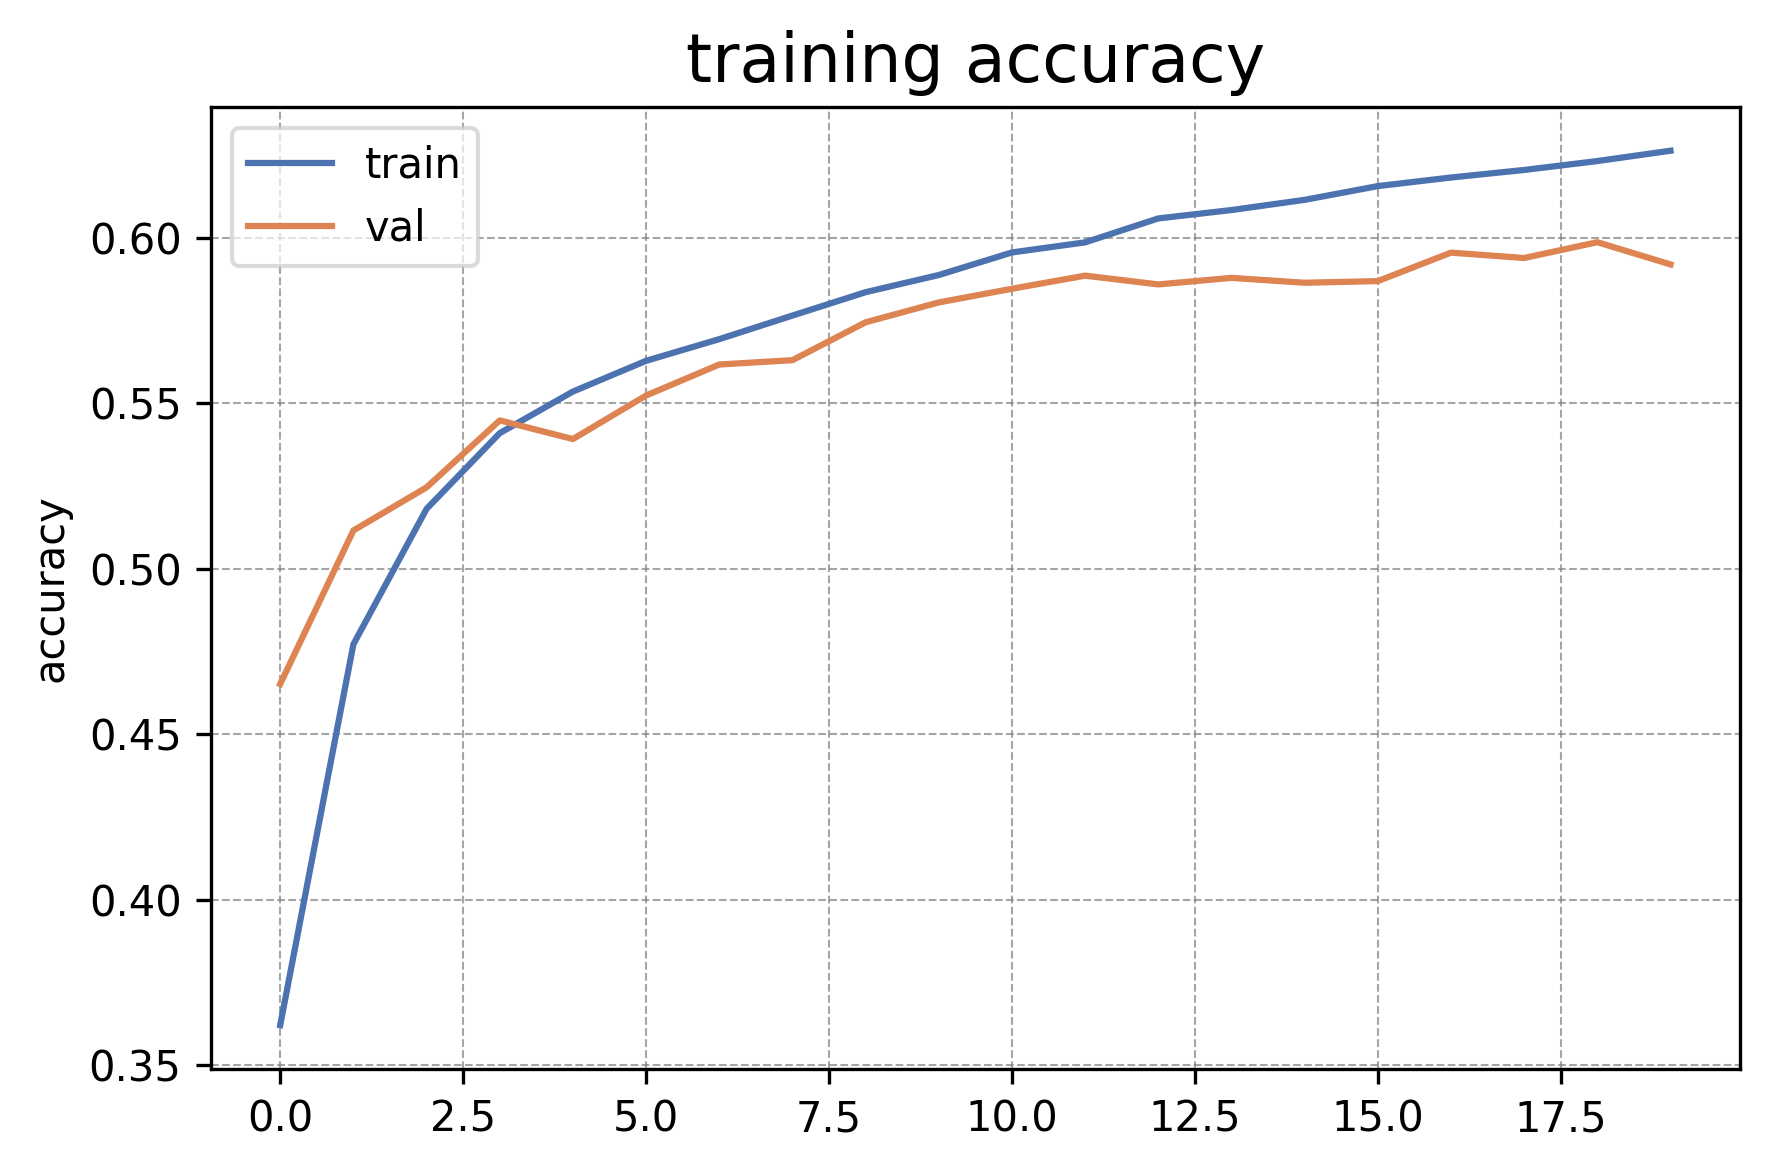

In [19]:
model, optimizer = get_model()
results = benchmark(model, optimizer, train_loader, val_loader, test_loader)

to_plot = {
    "train": results['all_train_acc'],
    "val": results['all_val_acc'],
}

plot(y=to_plot, xlabel="epoch")

## Node Feature Augmentation

### Why Positional Encoding?

In Graph Neural Networks (GNNs), unless nodes possess distinguishing features, isomorphic nodes will inevitably share identical embeddings. If the nodes already have meaningful features that uniquely identify them, this is ideal. However, failing this, additional feature augmentations are required. Basing this augmentation on the position of the node in the graph is known as positional encoding, and provides an inductive bias that helps with learning. A simplified example is provided below to illustrate its functionality.

In [20]:
import networkx as nx
from torch_geometric.utils import to_networkx
from pylab import show

Here, we create a small random graph to demonstrate on. We set the number of nodes to 10, make a constant feature of 1 for every node, and create 20 random edges. Feel free to adjust the number of nodes and edges if you'd like.

In [21]:
from torch_geometric.data import Data

num_nodes = 10
simple_x = torch.ones(num_nodes)
simple_edge_index = torch.randint(num_nodes, (2, num_nodes*2))
simple_data = Data(x=simple_x, edge_index=simple_edge_index, num_nodes=num_nodes)
simple_data, simple_data.x[0]

(Data(x=[10], edge_index=[2, 20], num_nodes=10), tensor(1.))

This random graph is visualized below, based on its features. All the nodes are the same color, blue, because we have constant features.

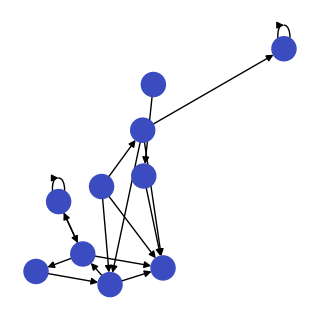

In [22]:
G = to_networkx(simple_data)
plt.figure(figsize=(3,3))
pos = nx.spring_layout(G)
node_color = [simple_data.x[node] for node in G.nodes()]
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Random Walk Positional Encoding (RWPE)

PyG supports two kinds of positional encoding, the first being Random Walk Positional Encoding. As the name implies, this method is based on the random walk diffusion process. Given a hyperparameter `walk_length` and node `v`, we calculate the probability that a random walk originating at `v` will land back on `v` after 1, 2, 3, ..., `walk_length` steps. This becomes a vector of `walk_length` length that we can concatenate to its original feature vector. Note that, since this is based on a random walk, if two nodes have the exact same neighborhood structure, they will still have the same positional encoding. The upside is that if the structures vary, even at a very far distance, this positional encoding will help differentiate them without using quite so many GNN layers.

In [23]:
walk_length = 3
rwpe = T.AddRandomWalkPE(walk_length=walk_length, attr_name=None)
rwpe(simple_data), rwpe(simple_data).x[0]

(Data(x=[10, 4], edge_index=[2, 20], num_nodes=10), tensor([1., 0., 0., 0.]))

To visualize the changed node features, we map the norm of the feature vector to colors. We can see that some of the nodes have clearly differentiated themselves, as we intended.

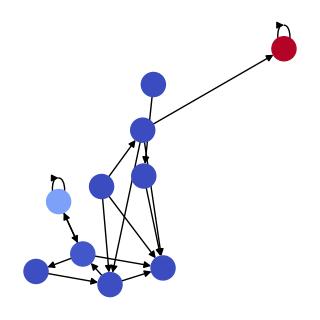

In [24]:
plt.figure(figsize=(3,3))
node_color = [torch.norm(rwpe(simple_data).x[node]) for node in G.nodes()]
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Laplacian Eigenvector Positional Encoding (LapPE)

If we want a positional encoding that will provide stronger uniqueness to each node, we can use the Laplacian Eigenvector Positional Encoding. This takes the first `lappe_k` eigenvectors of the graph's laplacian matrix (where `lappe_k` is a hyperparameter) and adds it to the node feature matrix. This is not only unique, but is distance-sensitive with respect to the Euclidean norm. One thing to be careful of is that since `lappe_k` is the number of eigenvectors to look at, this shouldn't exceed the number of nodes.

In [25]:
lappe_k = 3
lappe = T.AddLaplacianEigenvectorPE(k=lappe_k, is_undirected=True, attr_name=None)
lappe(simple_data), lappe(simple_data).x[0]

(Data(x=[10, 4], edge_index=[2, 20], num_nodes=10),
 tensor([1.0000, 0.7071, -0.0000, 0.0000]))

Below, we see that the node features have become much more varied. A limitation exists with this method as well, however, and it is that eigenvectors are sign-ambiguous. An eigenvector with the signs flipped is still the eigenvector of the same eigenvalue, and since we don't have a clear way of deciding which one to choose at each time, a model using this PE scheme must learn to be invariant towards the sign flip. 

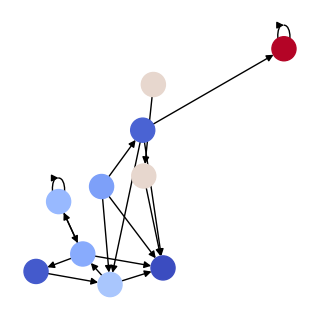

In [26]:
plt.figure(figsize=(3,3))
node_color = [np.linalg.norm(lappe(simple_data).x[node]) for node in G.nodes()]
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

### Benchmark Node Feature Augmentation Methods

Now, we'll benchmark these methods on ogbn-products. ogbn-products have node features that are already quite distinctive for each feature, so positional encodings don't actually improve the performance by much. But we can still see that it does not hurt performance, and is a stable addition for any dataset.

In [27]:
walk_length = 4
rwpe = T.AddRandomWalkPE(walk_length=walk_length, attr_name=None)

  0%|                                                                                  | 2/2842 [00:00<09:25,  5.02it/s]/home/adel/.local/lib/python3.8/site-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(
100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 95.84it/s]


Epoch 1: Train 0.0719 (37.36%) | Val 0.0605 (45.78%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 92.29it/s]


Epoch 2: Train 0.0581 (47.18%) | Val 0.0556 (49.31%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 92.29it/s]


Epoch 3: Train 0.0537 (50.85%) | Val 0.0520 (52.30%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 90.46it/s]


Epoch 4: Train 0.0504 (53.45%) | Val 0.0494 (54.15%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 82.99it/s]


Epoch 5: Train 0.0484 (54.83%) | Val 0.0484 (54.53%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 88.22it/s]


Epoch 6: Train 0.0470 (56.04%) | Val 0.0480 (55.01%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 91.97it/s]


Epoch 7: Train 0.0460 (56.70%) | Val 0.0460 (56.59%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 96.43it/s]


Epoch 8: Train 0.0451 (57.37%) | Val 0.0465 (56.27%)


100%|████████████████████████████████████████████████████████████████████████████████| 932/932 [00:09<00:00, 100.47it/s]


Epoch 9: Train 0.0442 (58.13%) | Val 0.0451 (57.62%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:12<00:00, 71.89it/s]


Epoch 10: Train 0.0435 (58.81%) | Val 0.0445 (57.79%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:13<00:00, 71.60it/s]


Epoch 11: Train 0.0427 (59.38%) | Val 0.0441 (57.88%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 83.55it/s]


Epoch 12: Train 0.0422 (59.75%) | Val 0.0432 (58.87%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 78.14it/s]


Epoch 13: Train 0.0416 (60.21%) | Val 0.0436 (58.35%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 80.05it/s]


Epoch 14: Train 0.0413 (60.54%) | Val 0.0428 (59.22%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:12<00:00, 77.07it/s]


Epoch 15: Train 0.0409 (60.84%) | Val 0.0428 (58.91%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 78.40it/s]


Epoch 16: Train 0.0404 (61.28%) | Val 0.0424 (59.64%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:14<00:00, 66.24it/s]


Epoch 17: Train 0.0400 (61.62%) | Val 0.0424 (59.41%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:11<00:00, 79.96it/s]


Epoch 18: Train 0.0397 (61.85%) | Val 0.0425 (59.09%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:10<00:00, 85.59it/s]


Epoch 19: Train 0.0393 (62.17%) | Val 0.0418 (59.77%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:12<00:00, 76.35it/s]


Epoch 20: Train 0.0390 (62.36%) | Val 0.0420 (60.05%)


100%|██████████████████████████████████████████████████████████████████████████████| 1519/1519 [00:14<00:00, 106.62it/s]


Train 0.0485 (54.29%)


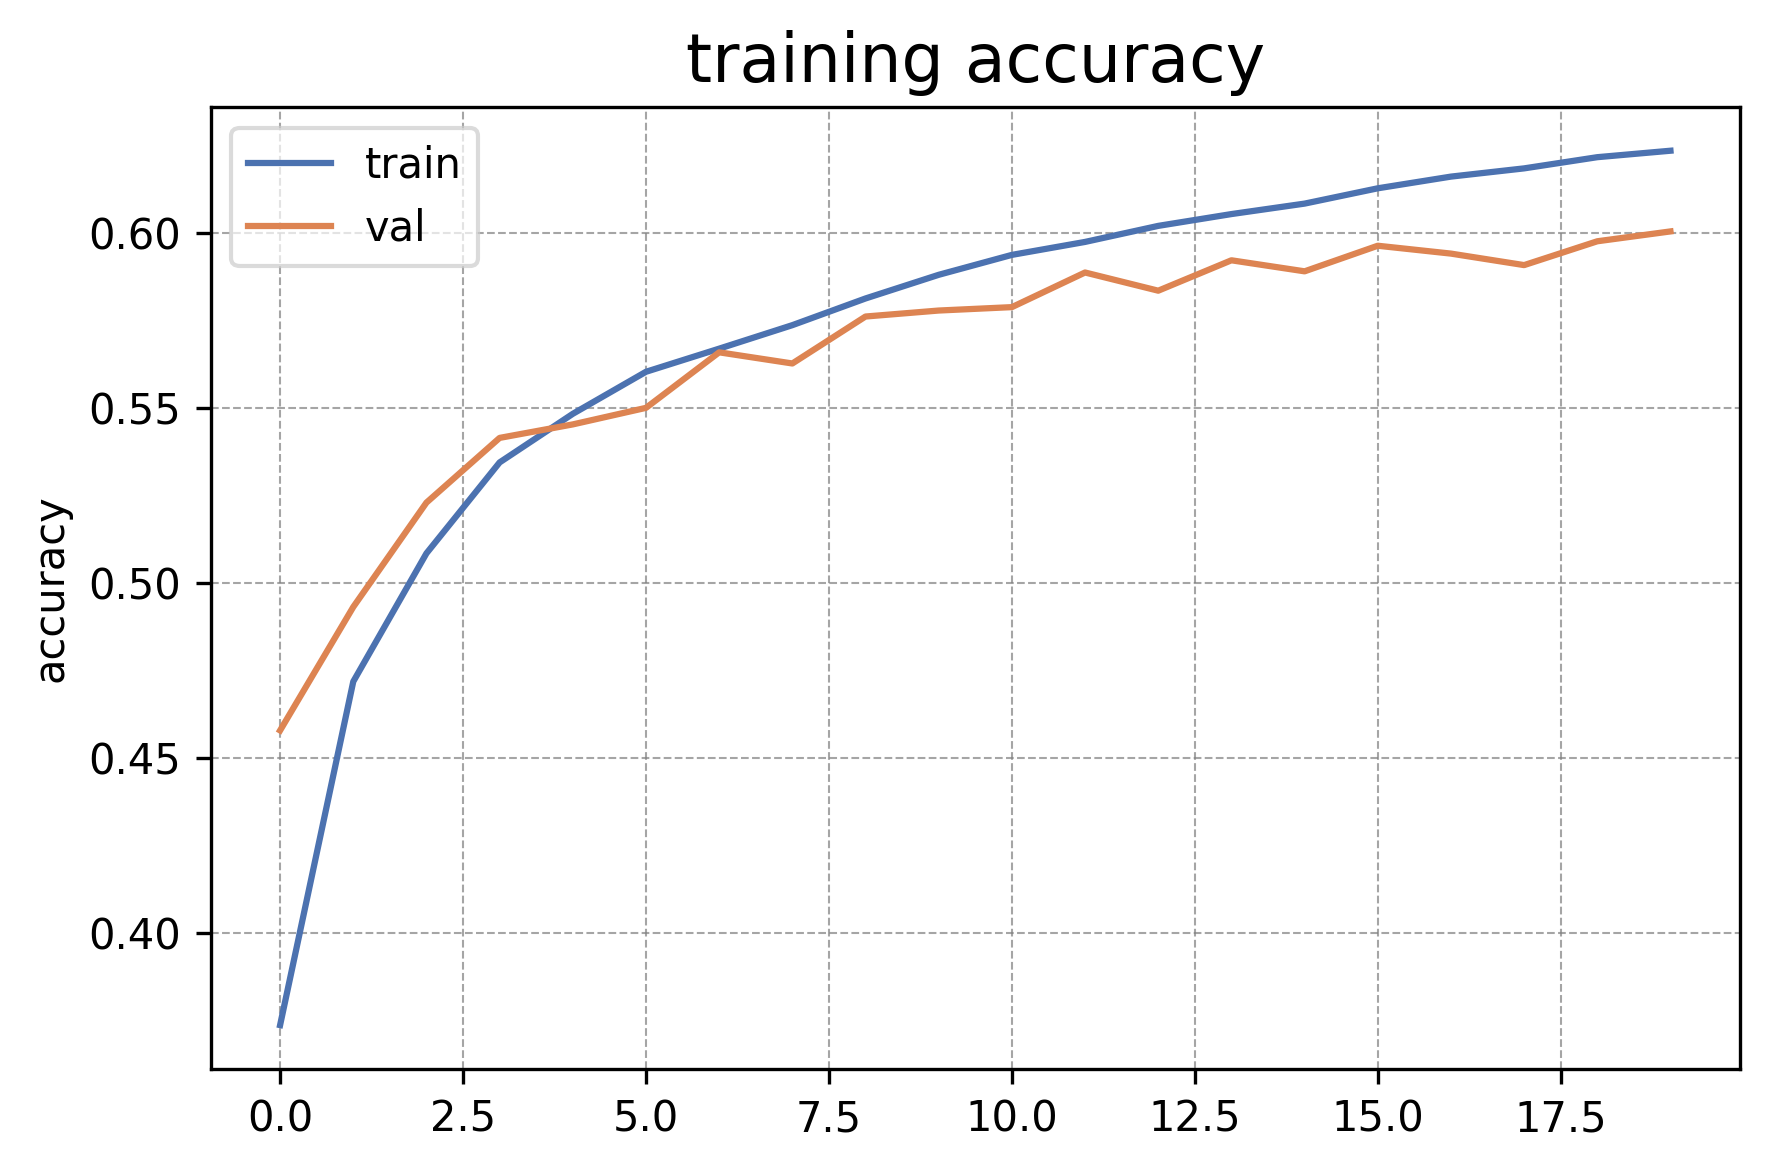

In [28]:
model, optimizer = get_model(input_dim=input_dim+walk_length)
results = benchmark(model, optimizer, train_loader, val_loader, test_loader, rwpe)

to_plot = {
    "train": results['all_train_acc'],
    "val": results['all_val_acc'],
}

plot(y=to_plot, xlabel="epoch")

In [29]:
lappe_k = 4
lappe = T.AddLaplacianEigenvectorPE(k=lappe_k, is_undirected=True, attr_name=None)

100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 33.34it/s]


Epoch 1: Train 0.0721 (36.75%) | Val 0.0605 (46.20%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:26<00:00, 35.55it/s]


Epoch 2: Train 0.0593 (45.97%) | Val 0.0567 (48.72%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 33.91it/s]


Epoch 3: Train 0.0546 (50.04%) | Val 0.0528 (51.32%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 33.50it/s]


Epoch 4: Train 0.0504 (53.43%) | Val 0.0491 (54.30%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:53<00:00, 17.40it/s]


Epoch 5: Train 0.0481 (55.05%) | Val 0.0481 (54.91%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:36<00:00, 25.59it/s]


Epoch 6: Train 0.0467 (56.09%) | Val 0.0473 (55.69%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:39<00:00, 23.59it/s]


Epoch 7: Train 0.0456 (56.98%) | Val 0.0463 (56.20%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:39<00:00, 23.49it/s]


Epoch 8: Train 0.0449 (57.68%) | Val 0.0461 (56.32%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:45<00:00, 20.33it/s]


Epoch 9: Train 0.0441 (58.25%) | Val 0.0454 (57.07%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 33.54it/s]


Epoch 10: Train 0.0435 (58.80%) | Val 0.0448 (57.55%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 34.29it/s]


Epoch 11: Train 0.0429 (59.23%) | Val 0.0444 (57.61%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:31<00:00, 29.73it/s]


Epoch 12: Train 0.0423 (59.64%) | Val 0.0437 (58.43%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 34.16it/s]


Epoch 13: Train 0.0418 (60.03%) | Val 0.0434 (58.67%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:27<00:00, 34.51it/s]


Epoch 14: Train 0.0414 (60.43%) | Val 0.0430 (59.16%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:33<00:00, 28.07it/s]


Epoch 15: Train 0.0409 (60.88%) | Val 0.0426 (59.25%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [01:14<00:00, 12.44it/s]


Epoch 16: Train 0.0405 (61.19%) | Val 0.0426 (59.64%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:38<00:00, 24.35it/s]


Epoch 17: Train 0.0400 (61.59%) | Val 0.0422 (59.54%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:31<00:00, 29.88it/s]


Epoch 18: Train 0.0397 (61.94%) | Val 0.0427 (58.86%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [00:34<00:00, 26.90it/s]


Epoch 19: Train 0.0393 (62.23%) | Val 0.0426 (59.14%)


100%|█████████████████████████████████████████████████████████████████████████████████| 932/932 [01:35<00:00,  9.72it/s]


Epoch 20: Train 0.0390 (62.41%) | Val 0.0418 (59.75%)


100%|███████████████████████████████████████████████████████████████████████████████| 1519/1519 [00:38<00:00, 39.77it/s]


Train 0.0486 (53.65%)


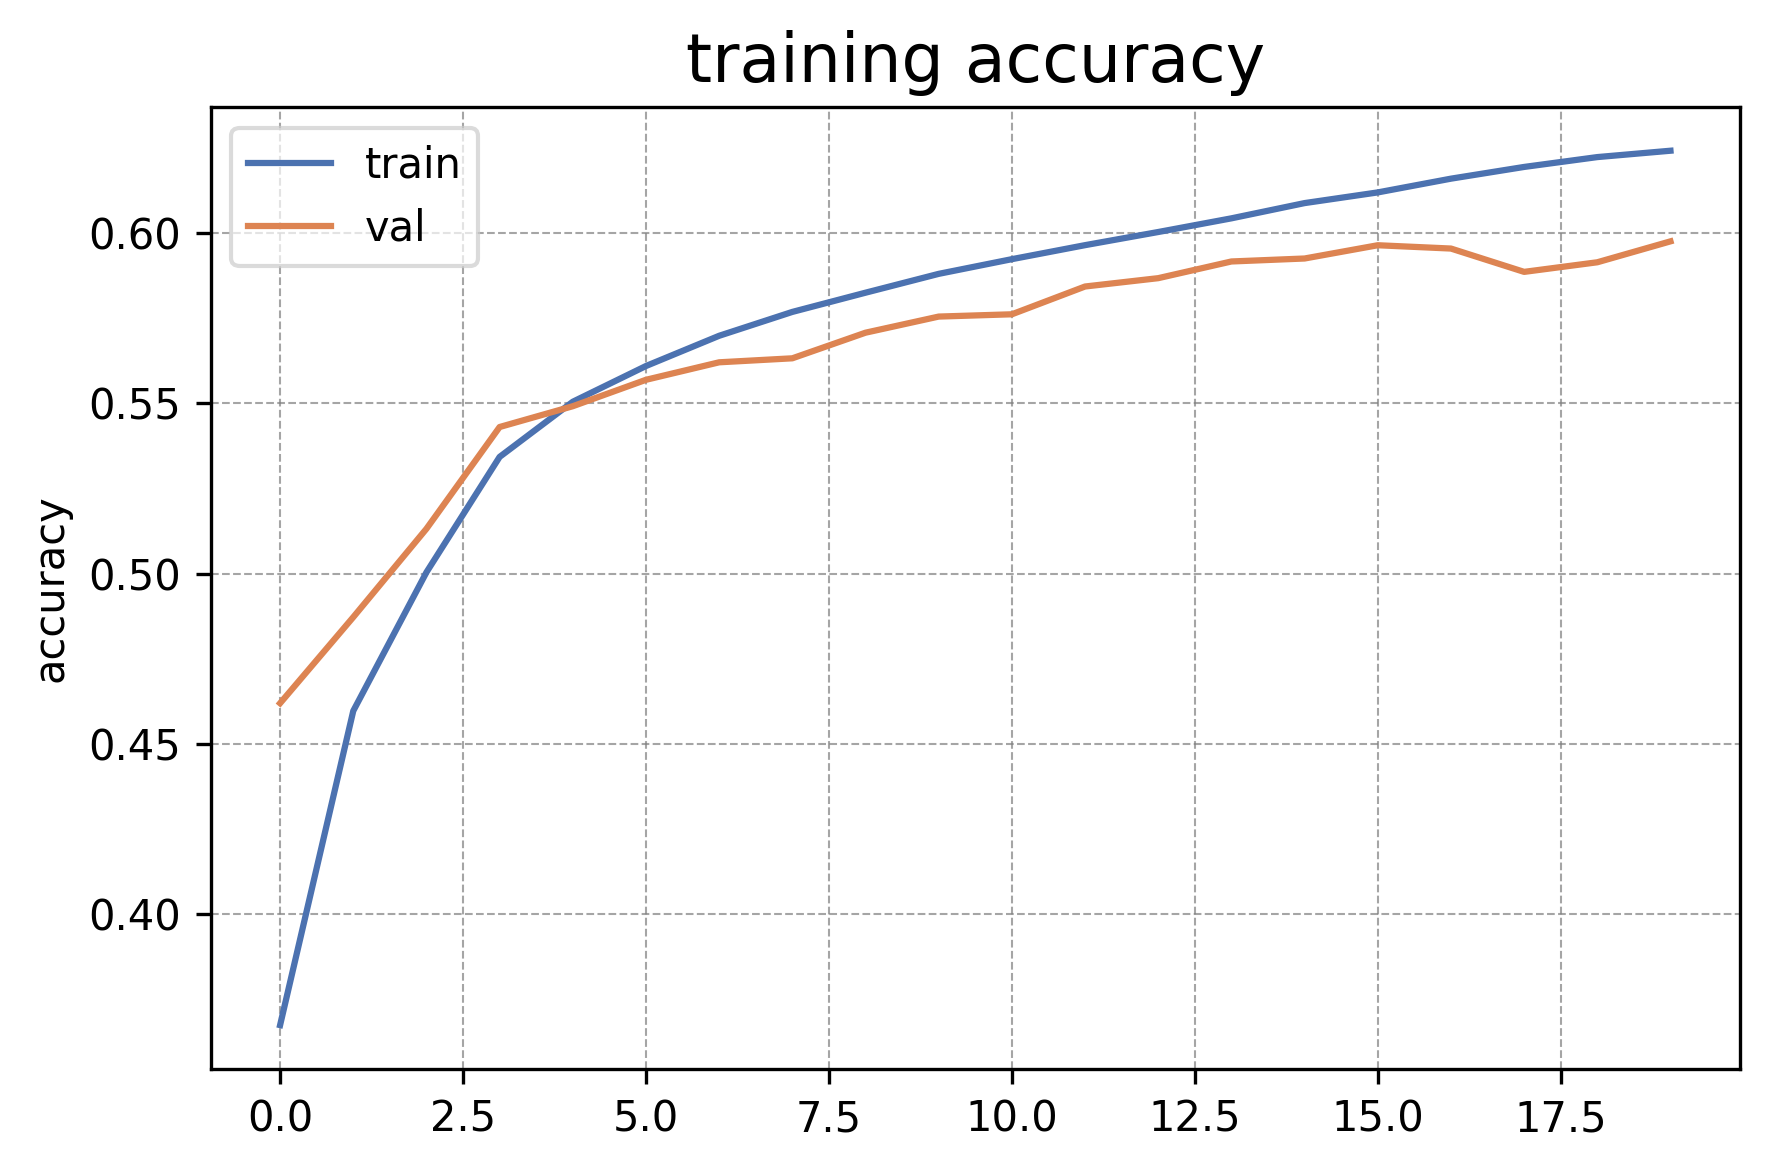

In [30]:
model, optimizer = get_model(input_dim=input_dim+lappe_k)
results = benchmark(model, optimizer, train_loader, val_loader, test_loader, lappe)

to_plot = {
    "train": results['all_train_acc'],
    "val": results['all_val_acc'],
}

plot(y=to_plot, xlabel="epoch")